<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Twitter_multimodal_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U "tensorflow-text==2.11.*"

In [2]:
!pip install -q tf-models-official==2.11.0

In [3]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import random
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def get_df(file):
    return pd.read_table(file,sep = '\t', lineterminator='\n')

In [5]:
train_df = get_df('/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/tweets.txt')
test_df = get_df('/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/tweets.txt')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


## Flatten the image folder structure for both devset and testset for ease of processing

In [ ]:
def flatten(directory, targetDir):
    if not os.path.exists(targetDir):
        os.makedirs(targetDir)
    for dirpath, _, filenames in os.walk(directory, topdown=False):
        for filename in filenames:
            i = 0
            source = os.path.join(dirpath, filename)
            target = os.path.join(targetDir, filename)

            shutil.move(source, target)

    print("Moved", directory, "to", targetDir)

In [ ]:
# Devset
SRC_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/Medieval2015_DevSet_Images/'
TARGET_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/'

flatten(SRC_DIR, TARGET_DIR)

Moved /content/drive/MyDrive/multimodal-news/mediaeval2015/devset/Medieval2015_DevSet_Images/ to /content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/


In [ ]:
# Testset
SRC_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/TestSetImages/'
TARGET_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/'

flatten(SRC_DIR, TARGET_DIR)

Moved /content/drive/MyDrive/multimodal-news/mediaeval2015/testset/TestSetImages/ to /content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/


## Initial Preprocessing of data

In [8]:
# TODO consider both the images and not just the first one
def return_first_image(row):
    return row['imageId(s)'].split(',')[0].strip()

In [9]:
train_df['first_image_id'] = train_df.apply (lambda row: return_first_image(row),axis=1)
test_df['first_image_id'] = test_df.apply (lambda row: return_first_image(row),axis=1)

In [10]:
images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

{'boston_fake_35', 'sandyB_real_4', 'sandyB_real_6', 'sochi_fake_1fake'}

In [11]:
images_test_dataset = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

{'eclipse_video_01', 'syrianboy_1', 'varoufakis_1'}

In [12]:
print(train_df.shape, test_df.shape)

(14277, 8) (3755, 8)


In [13]:
train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]

In [14]:
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]
print(train_df.shape, test_df.shape)

(14258, 8) (1923, 8)


In [15]:
train_text = train_df['tweetText'].tolist()
test_text = test_df['tweetText'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

In [16]:
len(train_text),len(train_images),len(trainY),len(test_text),len(test_images),len(testY)

(14258, 14258, 14258, 1923, 1923, 1923)

In [17]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

maximum length: 901


(array([   0.,    4.,  327.,  532.,  755.,  760.,  843.,  791.,  904.,
        2534., 2379.,  775., 1462., 1113., 1047.,   17.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 12., 15., 16.,
        18., 20., 25., 30.]),
 <BarContainer object of 16 artists>)

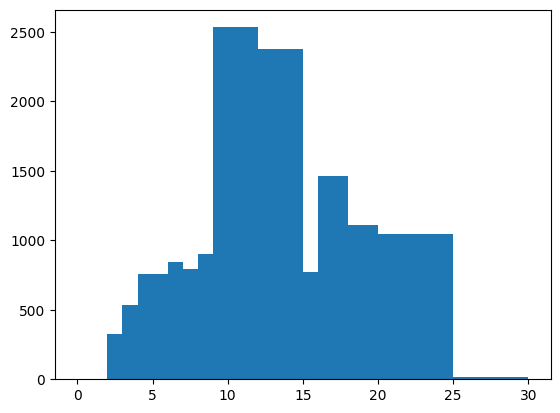

In [18]:
print("maximum length:", max_length(train_text))
plt.hist([len(s.split()) for s in train_text],bins=[0,1,2,3,4,5,6,7,8,9,12,15,16,18,20,25,30])

In [19]:
l=[len(s.split()) for s in train_text]
count=0.0
for i in l:
    if i>25:
        count+=1
print(count,len(l))
print(count/len(l))

17.0 14258
0.0011923130873895357


In [20]:
max_seq_length=25

# Visualize random tweets

In [21]:
DEV_IMAGE_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/'
TEST_IMAGE_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/'

In [22]:
def find_image_from_name_in_dir(image_name, dir):
  for name in glob.glob(dir+'/'+image_name+'.*'):
    return name

In [23]:
def visualise(index, text_df, image_df, train=True):
  path = DEV_IMAGE_DIR if train else TEST_IMAGE_DIR
  text = text_df[index]
  image_path = find_image_from_name_in_dir(image_df[index],path)
  image = plt.imread(image_path)
  plt.subplot(1, 1, 1)
  plt.title(text)
  plt.imshow(image)


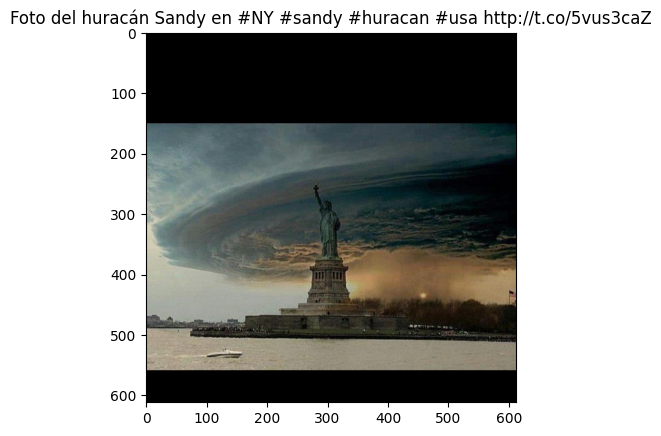

In [24]:
indx = random.randint(0, 3000)
visualise(indx, train_text, train_images)

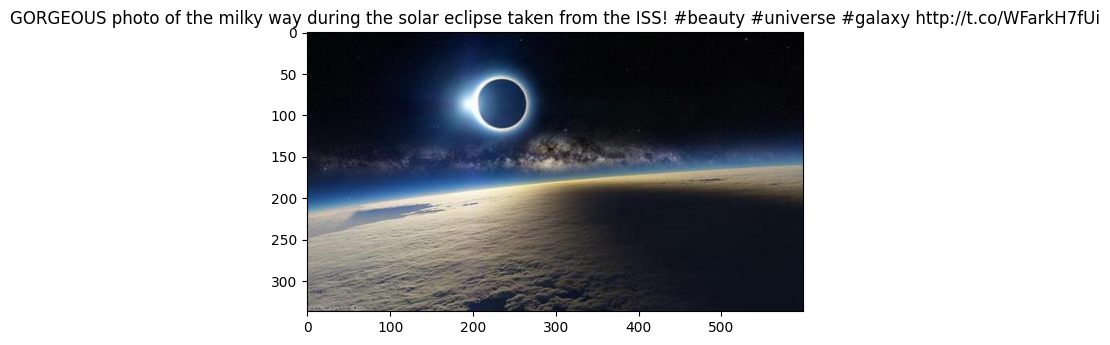

In [25]:
indx = random.randint(0, 1000)
visualise(indx, test_text, test_images, False)

## Start of modeling

In [26]:
# Alternate dataframes for modeling
train_df_model = train_df[['tweetText', 'first_image_id', 'label']]
train_df_model['label'] = train_df_model['label'].apply(lambda x: 1 if x=='real' else 0)
train_df_model['image_1'] = train_df_model['first_image_id'].apply(lambda x: find_image_from_name_in_dir(x, DEV_IMAGE_DIR))
train_df_model = train_df_model.drop(['first_image_id'], axis=1)
train_df_model.head(5)

,tweetText,label,image_1
0,¿Se acuerdan de la película: “El día después d...,0,/content/drive/MyDrive/multimodal-news/mediaev...
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,0,/content/drive/MyDrive/multimodal-news/mediaev...
2,"Buena la foto del Huracán Sandy, me recuerda a...",0,/content/drive/MyDrive/multimodal-news/mediaev...
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,0,/content/drive/MyDrive/multimodal-news/mediaev...
4,My fave place in the world #nyc #hurricane #sa...,0,/content/drive/MyDrive/multimodal-news/mediaev...


In [27]:
# Check to make sure all the first_image_id are tied with a path
train_df_model[train_df_model['image_1'].isnull()]

,tweetText,label,image_1


In [28]:
train_df_model['label'].value_counts()

0    9353
1    4905
Name: label, dtype: int64

In [29]:
test_df_model = test_df[['tweetText', 'first_image_id', 'label']]
test_df_model['label'] = test_df_model['label'].apply(lambda x: 1 if x=='real' else 0)
test_df_model['image_1'] = test_df_model['first_image_id'].apply(lambda x: find_image_from_name_in_dir(x, TEST_IMAGE_DIR))
test_df_model = test_df_model.drop(['first_image_id'], axis=1)
test_df_model.head(10)

,tweetText,label,image_1
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,0,/content/drive/MyDrive/multimodal-news/mediaev...
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,0,/content/drive/MyDrive/multimodal-news/mediaev...
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,0,/content/drive/MyDrive/multimodal-news/mediaev...
3,Eclipse from ISS.... http://t.co/En87OtvsU6,0,/content/drive/MyDrive/multimodal-news/mediaev...
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,0,/content/drive/MyDrive/multimodal-news/mediaev...
5,“@ebonfigli: Éclipse vue de l'ISS... Autre cho...,0,/content/drive/MyDrive/multimodal-news/mediaev...
6,Éclipse vue de l'ISS... Autre chose... http://...,0,/content/drive/MyDrive/multimodal-news/mediaev...
7,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,0,/content/drive/MyDrive/multimodal-news/mediaev...
8,Dit dus \0/ RT “@News_Executive: The Solar ecl...,0,/content/drive/MyDrive/multimodal-news/mediaev...
9,Photo: The Solar eclipse as seen from the Inte...,0,/content/drive/MyDrive/multimodal-news/mediaev...


In [30]:
# Check to make sure all the first_image_id are tied with a path
test_df_model[test_df_model['image_1'].isnull()]

,tweetText,label,image_1


In [31]:
test_df_model['label'].value_counts()

1    1207
0     716
Name: label, dtype: int64

### Handling imbalance of data in devset

In [33]:
from sklearn.model_selection import train_test_split
train_df_model, val_df_model = train_test_split(train_df_model, test_size=0.1, 
                                     stratify=train_df_model["label"].values, random_state=42)

# Data input pipeline

In [34]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [35]:
import numpy as np

In [36]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [37]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"])
bert_preprocess_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None, None)        0         
                                                                 
 packer (KerasLayer)         {'input_type_ids': (None  0         
                             , 128),                             
                              'input_word_ids': (None            
                             , 128),                             
                              'input_mask': (None, 12            
                             8)}                                 
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [38]:
idx = np.random.choice(len(train_df_model))
row = train_df.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: Sandy cubre NYC https://t.co/vjJrdsSG #awesome
Text 2: Sandy cubre NYC https://t.co/vjJrdsSG #awesome
Keys           :  ['input_type_ids', 'input_word_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  7525 21987  2890 16392 16770  1024  1013  1013  1056  1012  2522
  1013  1058  3501  3501], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [39]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'image_1', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [40]:
resize = (128, 128)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [41]:
def preprocess_image(image_path):
  extension = tf.strings.split(image_path,'.')[-1]
  image = tf.io.read_file(image_path)
  if extension == b"gif":
    image = tf.io.decode_image(image, 3, expand_animations=False)
  elif extension == b"png":
    image = tf.image.decode_png(image, 3)
  else:
    image = tf.image.decode_jpeg(image, 3)
  image = tf.image.resize(image, resize)
  return image

In [42]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [43]:
def preprocess_text_and_image(sample):
  image_1 = preprocess_image(sample["image_1"])
  text = preprocess_text(sample["tweetText"])
  return {"image_1": image_1, "text": text}

In [44]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [45]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [46]:
train_ds = prepare_dataset(train_df_model)
validation_ds = prepare_dataset(val_df_model, False)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

### Projection

In [47]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


### Vision encoder

In [48]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed_1)
    #embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

### Text Encoder

In [49]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

## MultiModal model

In [50]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=128,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention=False
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1])
    vision_projections = keras.layers.Dropout(dropout_rate)(vision_projections)
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)

    # Cross-attention.
    if attention:
        query_value_attention_seq = keras.layers.Attention(use_scale=True, dropout=0.2)(
            [vision_projections, text_projections]
        )


    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    if attention:
        concatenated = keras.layers.Concatenate()([concatenated, query_value_attention_seq])
    outputs = keras.layers.Dense(1, activation="sigmoid")(concatenated)
    return keras.Model([image_1, text_inputs], outputs)

## Multimodal Model without attention

In [51]:
multimodal_model = create_multimodal_model(attention=False)
multimodal_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                         

### Model Training

In [52]:
epochs = 10

In [53]:
checkpoint_filepath = '/content/drive/MyDrive/multimodal-news/model-checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [54]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [55]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)

history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=epochs, batch_size=32)

Epoch 1/10
401/401 [==============================] - 115s 244ms/step - loss: 0.0435 - binary_accuracy: 0.9851 - val_loss: 0.0079 - val_binary_accuracy: 0.9979
Epoch 2/10
401/401 [==============================] - 22s 54ms/step - loss: 0.0036 - binary_accuracy: 0.9991 - val_loss: 0.0029 - val_binary_accuracy: 0.9993
Epoch 3/10
401/401 [==============================] - 22s 54ms/step - loss: 5.5440e-04 - binary_accuracy: 0.9998 - val_loss: 0.0033 - val_binary_accuracy: 0.9986
Epoch 4/10
401/401 [==============================] - 22s 55ms/step - loss: 1.9727e-04 - binary_accuracy: 1.0000 - val_loss: 6.4426e-04 - val_binary_accuracy: 1.0000
Epoch 5/10
401/401 [==============================] - 23s 56ms/step - loss: 5.4053e-05 - binary_accuracy: 1.0000 - val_loss: 4.1487e-04 - val_binary_accuracy: 1.0000
Epoch 6/10
401/401 [==============================] - 23s 56ms/step - loss: 2.6374e-05 - binary_accuracy: 1.0000 - val_loss: 3.8644e-04 - val_binary_accuracy: 1.0000
Epoch 7/10
401/401 [==

In [56]:
#multimodal_model.load_weights(checkpoint_filepath)

In [57]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

61/61 [==============================] - 8s 128ms/step - loss: 2.9726 - binary_accuracy: 0.4327
Accuracy on the test set: 43.27%.


## Multimodal model with cross-attention

In [58]:
multimodal_model = create_multimodal_model(attention=True)
multimodal_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                         

### Model training

In [59]:
epochs = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [60]:
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)

history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=epochs, batch_size=32)

Epoch 1/10
401/401 [==============================] - 33s 61ms/step - loss: 0.0549 - binary_accuracy: 0.9797 - val_loss: 0.0057 - val_binary_accuracy: 0.9979
Epoch 2/10
401/401 [==============================] - 23s 56ms/step - loss: 0.0072 - binary_accuracy: 0.9979 - val_loss: 0.0032 - val_binary_accuracy: 0.9986
Epoch 3/10
401/401 [==============================] - 23s 58ms/step - loss: 0.0012 - binary_accuracy: 0.9997 - val_loss: 0.0019 - val_binary_accuracy: 0.9993
Epoch 4/10
401/401 [==============================] - 23s 57ms/step - loss: 2.5579e-04 - binary_accuracy: 1.0000 - val_loss: 7.8127e-04 - val_binary_accuracy: 1.0000
Epoch 5/10
401/401 [==============================] - 23s 58ms/step - loss: 1.0165e-04 - binary_accuracy: 1.0000 - val_loss: 2.3371e-04 - val_binary_accuracy: 1.0000
Epoch 6/10
401/401 [==============================] - 23s 57ms/step - loss: 3.5610e-05 - binary_accuracy: 1.0000 - val_loss: 2.6175e-04 - val_binary_accuracy: 1.0000
Epoch 7/10
401/401 [========

In [61]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

61/61 [==============================] - 3s 50ms/step - loss: 2.5323 - binary_accuracy: 0.4384
Accuracy on the test set: 43.84%.
